In [2]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

train_data_path = '/content/drive/MyDrive/Dataset_3/Dataset T V xml/Train'
valid_data_path = '/content/drive/MyDrive/Dataset_3/Dataset T V xml/Valid'

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    labels = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        labels.append(name)

    return labels

# Function to load and preprocess dataset
def load_data(dataset_path):
    images = []
    labels = []

    for filename in os.listdir(dataset_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(dataset_path, filename)
            xml_path = os.path.join(dataset_path, filename.replace('.jpg', '.xml'))

            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))  # Resize images to a consistent size

            label = parse_xml(xml_path)

            images.append(image)
            labels.append(label)

    return np.array(images), np.array(labels)

# Load training and validation data
train_images, train_labels = load_data(train_data_path)
valid_images, valid_labels = load_data(valid_data_path)

# Convert labels to one-hot encoding
unique_classes = list(set([label for sublist in train_labels for label in sublist]))
class_to_index = {cls: i for i, cls in enumerate(unique_classes)}

def convert_labels_to_one_hot(label):
    one_hot = np.zeros(len(unique_classes))
    for l in label:
        one_hot[class_to_index[l]] = 1
    return one_hot

train_label_map = np.array([convert_labels_to_one_hot(label) for label in train_labels])
valid_label_map = np.array([convert_labels_to_one_hot(label) for label in valid_labels])

num_classes = len(unique_classes)
print(num_classes)
print("Unique Labels:", unique_classes)


# Create the model (same as before)

# Create and configure the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Assuming 39 classes
])

# Compile the model (same as before)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
batch_size = 32
train_generator = datagen.flow(train_images, train_label_map, batch_size=batch_size)
valid_generator = datagen.flow(valid_images, valid_label_map, batch_size=batch_size)


model.fit(train_generator, epochs=50, validation_data=valid_generator)

# Save the model
model.save('image_classification_model.h5')

<ipython-input-3-a3caf220460e>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(labels)


37
Unique Labels: ['kopi', 'bakso', 'cakwe', 'pempek', 'apel', 'ayam betutu', 'kacang', 'sate', 'soto', 'crepes', 'burger', 'kentang', 'kerupuk', 'Roti', 'ayam', 'capcay', 'Tahu', 'Tempe', 'anggur', 'bakwan', 'es_krim', 'serabi', 'durian', 'jeruk', 'bubur', 'mie', 'fu_yung_hai', 'cumi', 'ikan', 'kebab', 'Nasi', 'batagor', 'nasi kuning', 'air', 'gudeg', 'donat', 'rawon']
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
22/22 [==============================] - 33s 998ms/step - loss: 3.6663 - accuracy: 0.1356 - val_loss: 2.9536 - val_accuracy: 0.2582
Epoch 2/50
22/22 [==============================] - 15s 681ms/step - loss: 2.4472 - accuracy: 0.3892 - val_loss: 2.4552 - val_accuracy: 0.4444
Epoch 3/50
22/22 [==============================] - 13s 593ms/step - loss: 1.8753 - accuracy: 0.5160 - val_loss: 2.1353 - val_accuracy: 0.4902
Epoch 4/50
22/22 [==============================] - 14s 629ms/step - loss: 1.5675 - accuracy: 0.5714 - val_loss: 1.9164 - val_accurac

KeyboardInterrupt: ignored

In [ ]:
from google.colab import files
files.download('image_classification_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 [==============================] - 2s 2s/step


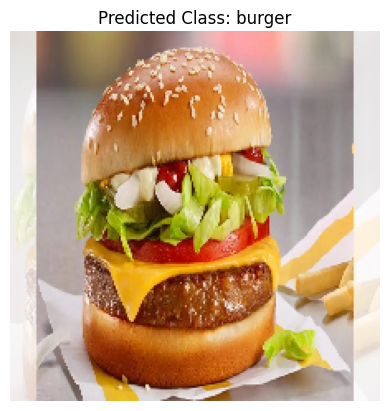

In [ ]:
test_image_path = '/content/drive/MyDrive/Dataset_3/Dataset T V xml/Train/burger_test-5-_jpg.rf.e64177f91222bb2e8a7f703c41d14474.jpg'  # Replace with the path to your test image
img = image.load_img(test_image_path, target_size=(224, 224)  )
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)
predicted_label = unique_classes[predicted_class]

# Display the original image and the predicted class
img = image.load_img(test_image_path, target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_label}')
plt.show()


In [ ]:

# Evaluate the model on the validation set
valid_predictions = model.predict(valid_images)

# Convert predictions to one-hot encoding
valid_predictions_one_hot = np.argmax(valid_predictions, axis=1)
valid_labels_one_hot = np.argmax(valid_label_map, axis=1)

# Generate the classification report
report = classification_report(valid_labels_one_hot, valid_predictions_one_hot, target_names=unique_classes)

# Print and/or use the 'report' variable as needed
print(report)

9/9 [==============================] - 4s 111ms/step
              precision    recall  f1-score   support

        Tahu       1.00      0.20      0.33         5
      bakwan       0.67      0.57      0.62         7
       gudeg       0.33      0.11      0.17         9
      kacang       0.56      0.83      0.67         6
        ayam       0.50      1.00      0.67         9
         mie       1.00      1.00      1.00         3
        ikan       0.86      0.75      0.80         8
       kebab       0.86      1.00      0.92         6
      durian       1.00      1.00      1.00         8
      crepes       0.75      0.38      0.50         8
        sate       1.00      0.80      0.89         5
       bubur       1.00      0.44      0.61        25
        soto       0.57      1.00      0.73         4
      burger       0.67      1.00      0.80         4
 nasi kuning       0.00      0.00      0.00         3
     batagor       0.89      0.89      0.89         9
      serabi       0.33     